<p style="font-family: helvetica,arial,sans-serif; font-size:2.0em;color:white; background-color: black">&emsp;<b>Green Walls</b></p>
    
<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Authored by: </b> Ryan Waites, ___, ___</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black; text-align:right"><b>Duration:</b> 90 mins&emsp;</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Level: </b>Beginner &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<b>Pre-requisite Skills:</b>Python</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>Scenario</b>

#### As a city planner, I want to determine the best potential locations for new green walls in the city of Melbourne. What locations would be most beneficial?

#### I would like to visualise factors such as pollution, temperatures and tree coverage.

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>What this Use Case will teach you</b>

At the end of this use case you will:
- understand how to access and collect data from Melbourne Open Data
- have explored datasets including Microclimate Sensor Readings & Locations, Tree Canopies and Pedestrian Sensor Readings & Locations.
- have combined and visualised multiple datasets over a map of the city.

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>A brief introduction to the datasets used</b>

### Issue being addressed

One of the many priorities of the City of Melbourne is the environment and climate moving forward as outlined in the councils [visions and goals](https://www.melbourne.vic.gov.au/about-council/vision-goals/Pages/climate-biodiversity-emergency.aspx). Green walls provide another option to assist in meeting several of these goals alongside the other solutions planned or in progress. Several considerations, requirements and benefits associated with the inclusion of green walls can be explored further in the [growing green guide](https://www.melbourne.vic.gov.au/SiteCollectionDocuments/growing-green-guide.pdf). As such we want to explore datasets that can provide insight into specific locations throughout the city where green walls can have a significant impact.

### Datasets overview

Among the data offered by the City of Melbourne, is that of its Microclimate Sensors and Pedestrian Sensors that have been placed in several locations around in the city. For this use case, we will access this information from the [Microclimate Sensor Readings](https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Readings/u4vh-84j8) and its paired dataset [Microclimate Sensor Locations](https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Locations/irqv-hjr4) which we'll use to identify each sensors location and current status. We'll perform the same process with the [Pedestrian Counting System - Monthly (counts per hour)](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp) dataset and its pair [Pedestrian Counting System - Sensor Locations](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234).

We'll be focusing on the Particulate Matter 10 (PM10) and temperature readings in particular, as a significant benefit of the installation of green walls is a potential reduction in these areas as well as the general increase in sustainability and overall health.

Extending on this, we'll also look to identify average levels of pedestrian traffic, as higher volume areas could see a greater benefit if the locations and environment are suitable.

[insert additional datasets used]

Finally we will be using the [Tree Canopies 2021 (Urban Forest)](https://data.melbourne.vic.gov.au/Environment/Tree-Canopies-2021-Urban-Forest-/krg7-hmyt) to get an overview of the existing tree cover throughout the city which we'll also visualise on our map.

### Package/Library Imports
To begin we will import the required libraries to perform our exploratory analysis and visualisation of the datasets.

The following are core packages required for this exercise:
- The sodapy package is required for accessing open data from SOCRATA compliant open data websites.
- The matplotlib.pyplot is required for the graphs used to visualise our data.
- The branca.colormap is required to provide a colormap for use in mapping visualisations.
- The folium package is required for the mapping visualisations

In [1]:
import os

import numpy as np
import pandas as pd
from datetime import datetime
from sodapy import Socrata
import matplotlib.pyplot as plt
import branca.colormap as cm
import folium
from folium.plugins import MarkerCluster

In [2]:
dataset_id = 'u4vh-84j8' # Melbourne Microclimate Sensor Readings

apptoken = os.environ.get("SODAPY_APPTOKEN") # Anonymous app token
domain = "data.melbourne.vic.gov.au"
client = Socrata(domain, apptoken) # Open Dataset connection

#### Information regarding standards for PM10 and 2.5:
##### https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm10-particles-in-the-air 
##### https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air

### Retrieve all data from PM10 24 hour average sensors, with erroneous values removed, from within the last year. 

In [3]:
# Retrieve hourly rolling 24 hour averages for PM10 since April 2021. 
dataresource = client.get(dataset_id, where="type='PM10-EPA-1h-NOPK-EPA-24h' AND local_time > '2021-04-11T20:00:00' LIMIT 75000")
pm10_dataset = pd.DataFrame.from_dict(dataresource)
pm10_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57558 entries, 0 to 57557
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57558 non-null  object
 1   site_id         57558 non-null  object
 2   gateway_hub_id  57558 non-null  object
 3   sensor_id       57558 non-null  object
 4   value           57540 non-null  object
 5   local_time      57558 non-null  object
 6   type            57558 non-null  object
 7   units           57558 non-null  object
dtypes: object(8)
memory usage: 3.5+ MB


In [4]:
# Convert to correct data types
pm10_dataset[['id', 'site_id']] = pm10_dataset[['id', 'site_id']].astype(int)
pm10_dataset[['value']] = pm10_dataset[['value']].astype(float)
pm10_dataset['local_time'] = pd.to_datetime(pm10_dataset['local_time'] )
pm10_dataset = pm10_dataset.convert_dtypes()

pm10_dataset.dtypes

id                         Int32
site_id                    Int32
gateway_hub_id            string
sensor_id                 string
value                    float64
local_time        datetime64[ns]
type                      string
units                     string
dtype: object

### With datatypes sorted, view the total entries from each site and their mean PM10 recordings.

In [5]:
groupbyfields = ['site_id']
aggregatebyfields = ["count", "mean"]

# Create new DataFrame with value counts and mean values for each site.
pm10SiteCount = pd.DataFrame(pm10_dataset.groupby(groupbyfields, as_index=False)['value'].agg(aggregatebyfields)
                             .add_prefix('value_'))
pm10SiteCount = pm10SiteCount.reset_index()
pm10SiteCount

,site_id,value_count,value_mean
0,1001,1005,28.424478
1,1005,1406,28.789687
2,1006,869,25.733487
3,1007,8360,24.760467
4,1008,665,25.643759
5,1009,7693,28.425868
6,1010,7481,24.635156
7,1011,6109,23.611229
8,1012,5311,27.217511
9,1013,5251,26.425214


### With the annual average national standard at 25 µg/m3 (Victorian standard 20 µg/m3), we can see that 9 of 13 sites have exceeded it and all are exceeding the Victorian standard. However, theres a varying amount of data collected for each site so we should check the first and last recorded dates.

In [6]:
groupbyfields = ['site_id']
aggregatebyfields = {'local_time': ["min", "max"]}

# Create new DataFrame highlighting start and end dates.
recordingDates= pd.DataFrame(pm10_dataset.groupby(groupbyfields, as_index=False).agg(aggregatebyfields))
recordingDates

site_id          local_time                    
                           min                 max
0     1001 2021-04-11 21:00:00 2021-06-12 23:00:00
1     1005 2021-04-11 21:00:00 2021-06-13 00:00:00
2     1006 2021-05-20 00:00:00 2021-06-28 00:00:00
3     1007 2021-05-20 00:00:00 2022-05-18 02:00:00
4     1008 2021-06-15 11:00:00 2021-09-20 18:00:00
5     1009 2021-06-15 09:00:00 2022-05-18 02:00:00
6     1010 2021-06-29 00:00:00 2022-05-18 02:00:00
7     1011 2021-08-25 19:00:00 2022-05-18 02:00:00
8     1012 2021-09-20 19:00:00 2022-05-18 02:00:00
9     1013 2021-09-20 19:00:00 2022-05-10 21:00:00
10    1014 2021-09-20 19:00:00 2022-05-18 02:00:00
11    1015 2021-09-20 19:00:00 2022-05-18 02:00:00
12    1016 2021-09-20 19:00:00 2022-05-18 02:00:00

### As evident above, it appears no sites actually have all of the last 12 months worth of data, making annual averages difficult to rely upon without looking further back for a better overall view.

### Lets obtain all available data and look at the averages by months and see if we can see any clear trends that indicate a likely reduction of these averages within a yearly timeframe.

In [7]:
# Retrieve all hourly rolling 24 hour averages for PM10. 
dataresource = client.get(dataset_id, where="type='PM10-EPA-1h-NOPK-EPA-24h' LIMIT 100000")
all_pm10_dataset = pd.DataFrame.from_dict(dataresource)
all_pm10_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99683 entries, 0 to 99682
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              99683 non-null  object
 1   site_id         99683 non-null  object
 2   gateway_hub_id  99683 non-null  object
 3   sensor_id       99683 non-null  object
 4   value           99662 non-null  object
 5   local_time      99683 non-null  object
 6   type            99683 non-null  object
 7   units           99683 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [8]:
# Convert to correct data types
all_pm10_dataset[['id', 'site_id']] = all_pm10_dataset[['id', 'site_id']].astype(int)
all_pm10_dataset[['value']] = all_pm10_dataset[['value']].astype(float)
all_pm10_dataset['local_time'] = pd.to_datetime(all_pm10_dataset['local_time'] )
all_pm10_dataset = all_pm10_dataset.convert_dtypes()

all_pm10_dataset.dtypes

id                         Int32
site_id                    Int32
gateway_hub_id            string
sensor_id                 string
value                    float64
local_time        datetime64[ns]
type                      string
units                     string
dtype: object

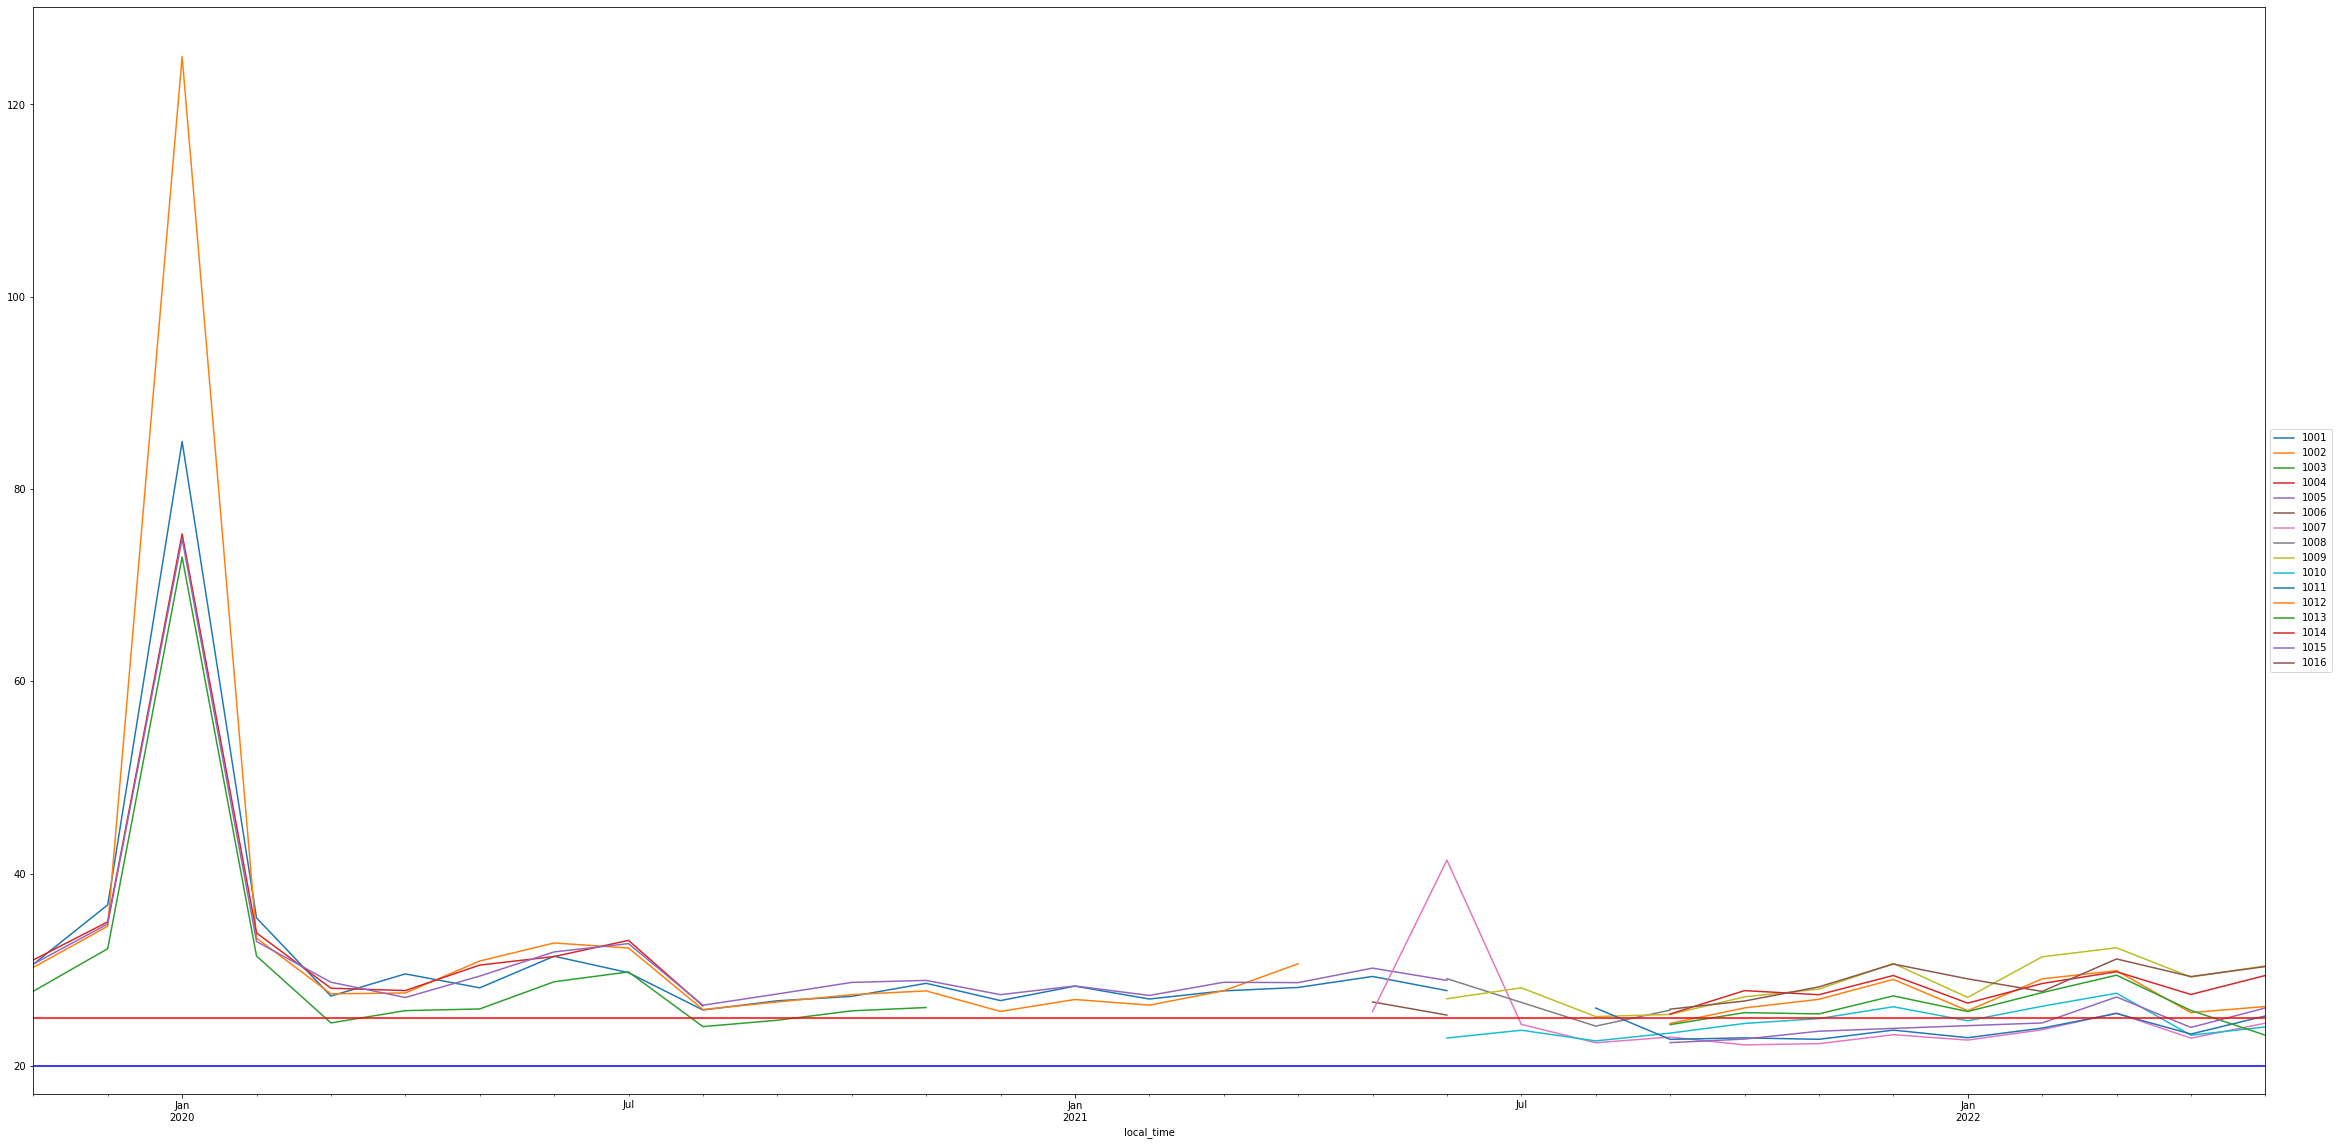

In [9]:
groupbyfields = ['site_id', pd.Grouper(key='local_time', freq='M')]
aggregatebyfields = {'value':['mean']}

# Create new DataFrame grouping the averages of each month since recording first began.
Pm10AllSiteCount = pd.DataFrame(all_pm10_dataset.groupby(groupbyfields).agg(aggregatebyfields))
Pm10AllSiteCount = Pm10AllSiteCount.reset_index()

# Plot this in a timeline graph
fig, ax = plt.subplots(1,1);
Pm10AllSiteCount.groupby(['site_id']).plot(x='local_time', y='value', ax=ax, figsize=(40,20))
plt.legend([v[0] for v in Pm10AllSiteCount.groupby('site_id')['site_id']], loc='center left', bbox_to_anchor=(1, 0.5))

# Add lines representing the national and victorian annual standards.
ax.axhline(y = 25, color = 'r', label='National Annual Standard')
ax.axhline(y = 20, color = 'b', label='Victorian Annual Standard')

### We can see all sites mostly follow a similar trend however based on current and past data there's no reason to expect any significant drops that would reach Victorias annual standard. Of the sites still currently recording data, sites 1009, 1012, 1016 & 1014 are showing the highest averages.

#### Looking purely at the last year of recordings.

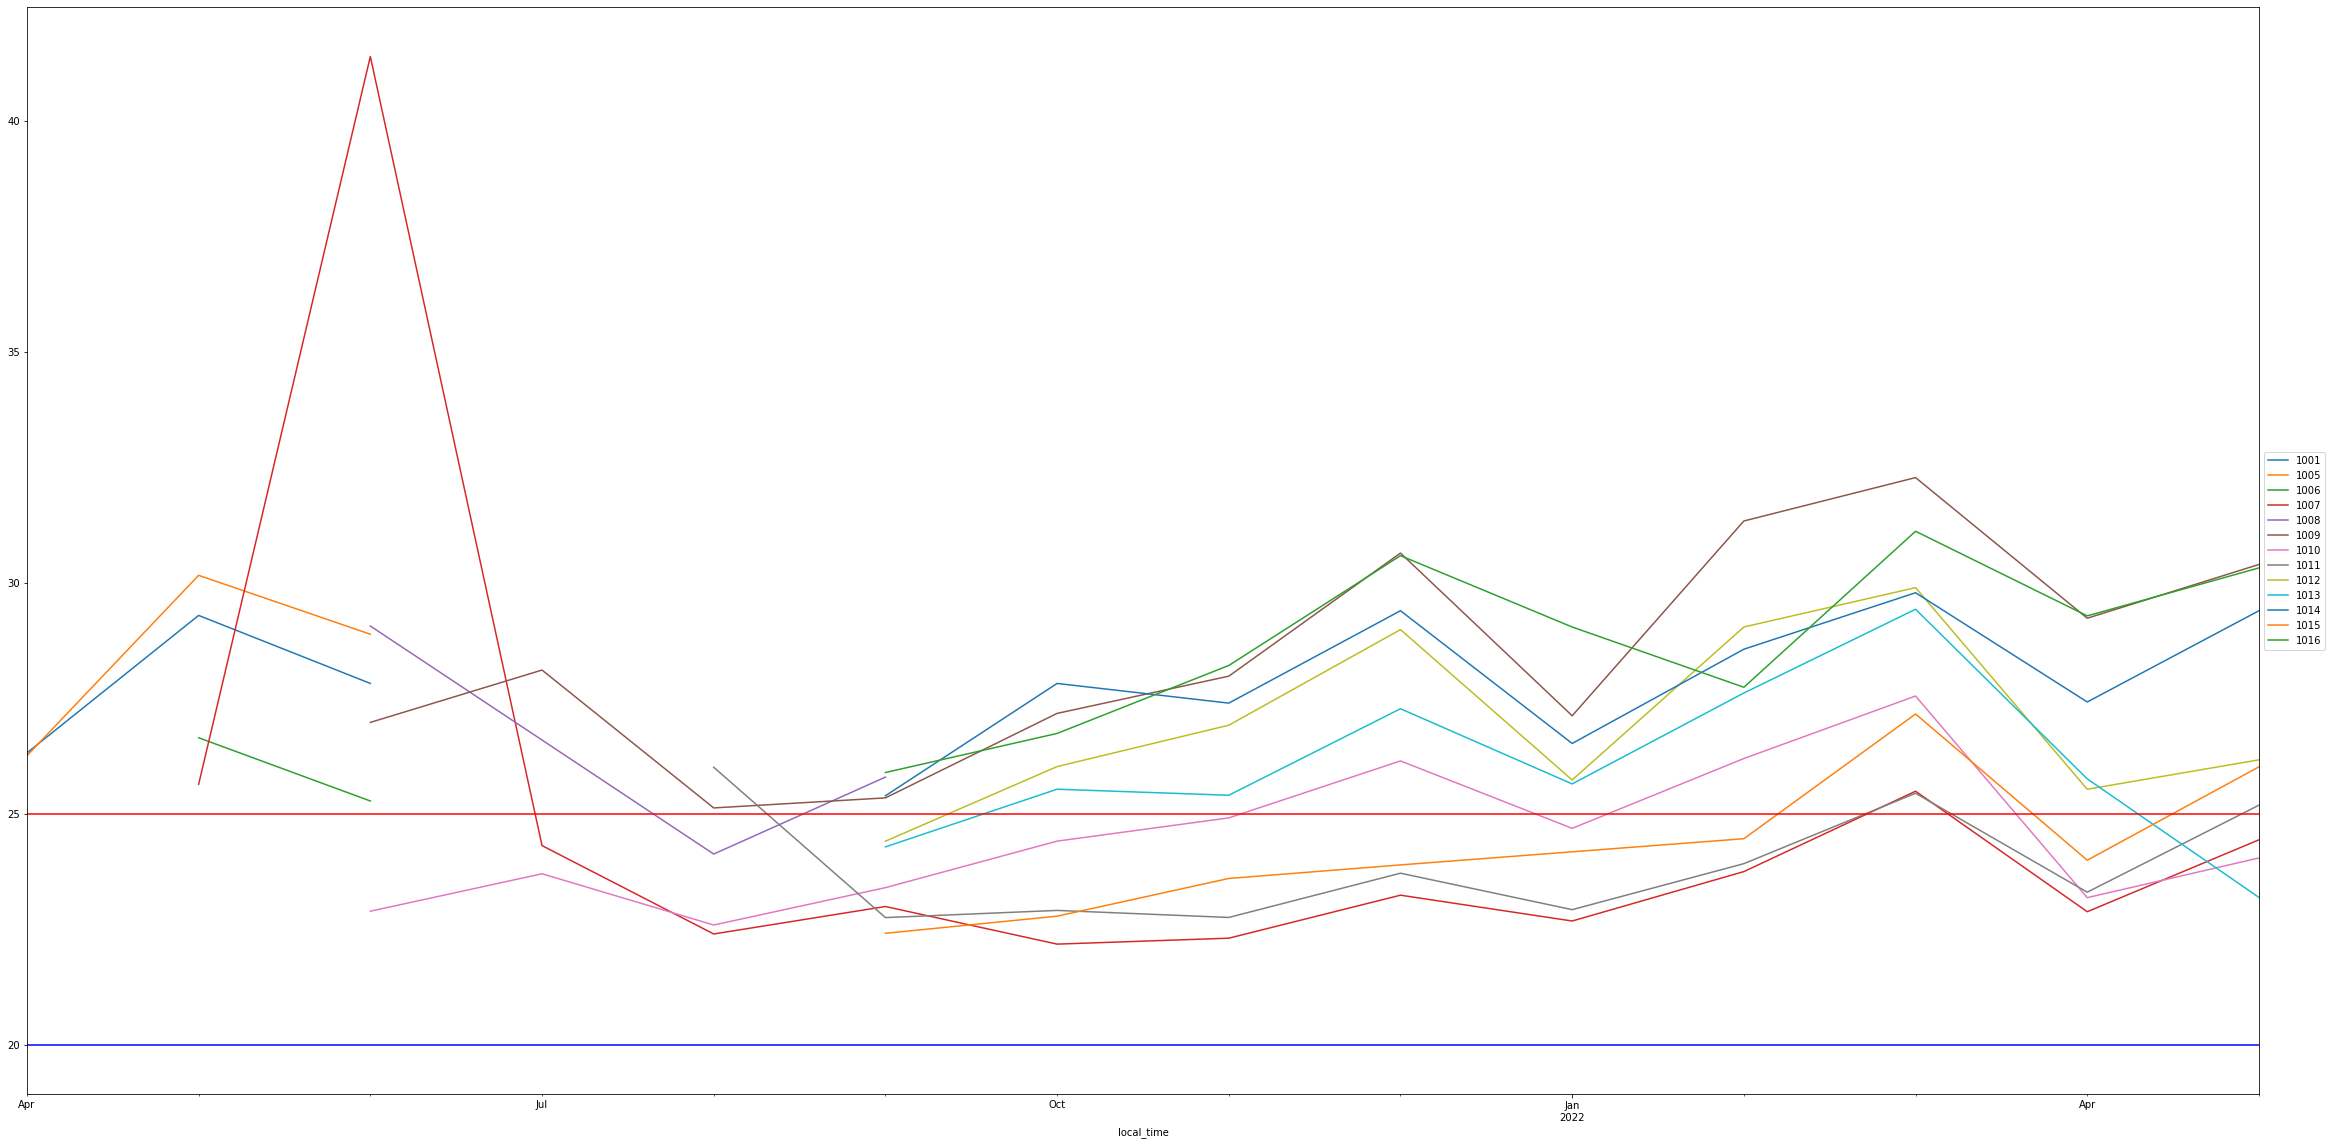

In [10]:
groupbyfields = ['site_id', pd.Grouper(key='local_time', freq='M')]
aggregatebyfields = {'value':['mean']}

# Create new DataFrame grouping the averages of each month over the last year.
Pm10AllSiteCount = pd.DataFrame(pm10_dataset.groupby(groupbyfields).agg(aggregatebyfields))
Pm10AllSiteCount = Pm10AllSiteCount.reset_index()

# Plot this in a timeline graph
fig, ax = plt.subplots(1,1);
Pm10AllSiteCount.groupby(['site_id']).plot(x='local_time', y='value', ax=ax, figsize=(40,20))
plt.legend([v[0] for v in Pm10AllSiteCount.groupby('site_id')['site_id']], loc='center left', bbox_to_anchor=(1, 0.5))

# Add lines representing the national and victorian annual standards.
ax.axhline(y = 25, color = 'r', label='National Annual Standard')
ax.axhline(y = 20, color = 'b', label='Victorian Annual Standard')

### Let's now look at merging our sensor data with the sensors location dataset to use for visualisation.
##### https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Locations/irqv-hjr4

In [11]:
dataset_id = 'irqv-hjr4' # Melbourne Microclimate Sensor Locations
dataresource = client.get(dataset_id)

In [12]:
# Retrieve data from Microclimate Sensor Locations dataset. 
location_dataset = pd.DataFrame.from_dict(dataresource)
location_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   site_id         16 non-null     object
 1   gateway_hub_id  16 non-null     object
 2   site_status     16 non-null     object
 3   start_reading   16 non-null     object
 4   end_reading     7 non-null      object
 5   longitude       16 non-null     object
 6   latitude        16 non-null     object
 7   location        16 non-null     object
 8   last_data       9 non-null      object
dtypes: object(9)
memory usage: 1.2+ KB


In [13]:
# Set site_id to int for merging
location_dataset[['site_id']] = location_dataset[['site_id']].astype(int)
location_dataset[['longitude', 'latitude']] = location_dataset[['longitude', 'latitude']].astype(float)

In [14]:
# Merging sensor location data with reading data.
pm10 = pd.merge(pm10SiteCount, location_dataset, on='site_id')

In [15]:
# Drop unused columns and convert remaining to string datatypes.
pm10 = pm10.drop(['gateway_hub_id', 'end_reading', 'last_data', 'location'], axis=1)
pm10 = pm10.convert_dtypes()
pm10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 12
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   site_id        13 non-null     Int64  
 1   value_count    13 non-null     Int64  
 2   value_mean     13 non-null     float64
 3   site_status    13 non-null     string 
 4   start_reading  13 non-null     string 
 5   longitude      13 non-null     float64
 6   latitude       13 non-null     float64
dtypes: Int64(2), float64(3), string(2)
memory usage: 858.0 bytes


In [16]:
# Drop retired sensors, remaining sensors running since at least September 2021.
pm10 = pm10[pm10['site_status'] != 'R']
pm10

,site_id,value_count,value_mean,site_status,start_reading,longitude,latitude
3,1007,8360,24.760467,C,2021-05-20T00:00:00.000,144.951841,-37.822447
5,1009,7693,28.425868,C,2021-06-14T00:00:00.000,144.965711,-37.816854
6,1010,7481,24.635156,C,2021-06-29T00:00:00.000,144.952228,-37.822487
7,1011,6109,23.611229,C,2021-07-07T00:00:00.000,144.952228,-37.822209
8,1012,5311,27.217511,C,2021-09-17T00:00:00.000,144.970006,-37.813320
9,1013,5251,26.425214,C,2021-09-17T00:00:00.000,144.956395,-37.811931
10,1014,5494,28.080688,C,2021-09-17T00:00:00.000,144.967228,-37.817487
11,1015,4214,24.376175,C,2021-09-17T00:00:00.000,144.972506,-37.810265
12,1016,3682,28.823004,C,2021-09-17T00:00:00.000,144.960562,-37.812765


### Now we're done manipulating the PM data and it's ready for visualisation at the end, so let's work on our other datasets.

### Pedestrian Counting System - Monthly (counts per hour) Dataset. Retrieve all data recorded since the 11th of April 2021 to help identify high pedestrian traffic areas in conjunction with the other factors examined so far.

In [17]:
dataset_id = 'b2ak-trbp' # Pedestrian Counting Dataset
dataresource = client.get(dataset_id, where="Date_Time > '2021-04-11T20:00:00' LIMIT 7500000") # Select years worth of recording
pedest_count = pd.DataFrame.from_dict(dataresource)

In [18]:
pedest_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632002 entries, 0 to 632001
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             632002 non-null  object
 1   date_time      632002 non-null  object
 2   year           632002 non-null  object
 3   month          632002 non-null  object
 4   mdate          632002 non-null  object
 5   day            632002 non-null  object
 6   time           632002 non-null  object
 7   sensor_id      632002 non-null  object
 8   sensor_name    632002 non-null  object
 9   hourly_counts  632002 non-null  object
dtypes: object(10)
memory usage: 48.2+ MB


In [19]:
# Drop columns not being used
pedest_count = pedest_count.drop(['id', 'year', 'month', 'day', 'mdate', 'time'], axis=1)

# Convert to correct data types
pedest_count[[ 'sensor_id', 'hourly_counts']] = pedest_count[['sensor_id', 'hourly_counts']].astype(int)
pedest_count['date_time'] = pd.to_datetime(pedest_count['date_time'] )
pedest_count = pedest_count.convert_dtypes()

pedest_count.dtypes

date_time        datetime64[ns]
sensor_id                 Int32
sensor_name              string
hourly_counts             Int32
dtype: object

### With columns and datatypes sorted, lets focus on the average hourly pedestrian count for each sensor.

In [20]:
groupbyfields = ['sensor_id']
aggregatebyfields = ["mean"]

# Create new DataFrame with mean values for each site.
pedest_mean = pd.DataFrame(pedest_count.groupby(groupbyfields)['hourly_counts'].agg(aggregatebyfields).astype(int)
                           .add_prefix('hourly_counts_'))
pedest_mean = pedest_mean.reset_index()
pedest_mean

,sensor_id,hourly_counts_mean
0,1,619
1,2,367
2,3,556
3,4,778
4,5,674
...,...,...
70,78,43
71,79,368
72,84,800
73,85,77


### Lets now obtain the paired dataset containing each sensors location.

In [21]:
dataset_id = 'h57g-5234' # Pedestrian Counting Sensor Locations Dataset
dataresource = client.get(dataset_id)
pedest_loc = pd.DataFrame.from_dict(dataresource)

In [22]:
pedest_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sensor_id           78 non-null     object
 1   sensor_description  78 non-null     object
 2   sensor_name         78 non-null     object
 3   installation_date   78 non-null     object
 4   status              78 non-null     object
 5   direction_1         74 non-null     object
 6   direction_2         74 non-null     object
 7   latitude            78 non-null     object
 8   longitude           78 non-null     object
 9   location            78 non-null     object
 10  note                10 non-null     object
dtypes: object(11)
memory usage: 6.8+ KB


In [23]:
# Drop columns not liekly to be used
pedest_loc = pedest_loc.drop(['sensor_description', 'direction_1', 'direction_2', 'location', 'note'], axis=1)

# Convert to correct data types
pedest_loc[[ 'sensor_id']] = pedest_loc[['sensor_id']].astype(int)
pedest_loc[['latitude', 'longitude']] = pedest_loc[['latitude', 'longitude']].astype(float)
pedest_loc['installation_date'] = pd.to_datetime(pedest_loc['installation_date'])
pedest_loc = pedest_loc.convert_dtypes()

pedest_loc.dtypes

sensor_id                     Int32
sensor_name                  string
installation_date    datetime64[ns]
status                       string
latitude                    float64
longitude                   float64
dtype: object

In [24]:
# Merging sensor location data with counting data.
pedest = pd.merge(pedest_mean, pedest_loc, on='sensor_id')

#### With our data merged, can see below that only one sensor (ID: 79) was installed during the period of data we're examining, we should take note of this as it could factor into its average. Otherwise we have a complete timefrime.

In [25]:
pedest

,sensor_id,hourly_counts_mean,sensor_name,installation_date,status,latitude,longitude
0,1,619,Bou292_T,2009-03-24,A,-37.813494,144.965153
1,2,367,Bou283_T,2009-03-30,A,-37.813807,144.965167
2,3,556,Swa295_T,2009-03-25,A,-37.811015,144.964295
3,4,778,Swa123_T,2009-03-23,A,-37.814880,144.966088
4,5,674,PriNW_T,2009-03-26,A,-37.818742,144.967877
...,...,...,...,...,...,...,...
67,75,37,SprFli_T,2020-12-18,A,-37.815153,144.974677
68,76,57,KenMac_T,2021-02-20,A,-37.794538,144.930362
69,77,153,HarEsP_T,2021-03-25,A,-37.814414,144.944330
70,78,43,HarEsB_T,2021-03-30,A,-37.814716,144.944651


# Mapping Visualisation

## Pedestrian Traffic
### Visualise the hourly average for pedestrian traffic obtained with the blue circles increased size, relative to one another, indicative of higher pedestrian counts.

In [26]:
# Sections before and after where lat/long is added in order to open 
# a new tab containing the google street view of the location. 
linkPart1 = "<br><a href=https://www.google.com/maps/@?api=1&map_action=pano&viewpoint="
linkPart2 = "&source=outdoor\" target=\"_blank\">Street&nbspView</a>"

# Colour map based on PM10 values.
colormap = cm.LinearColormap(colors=['green','yellow','red'], index=[20, 25, 30], vmin=20, vmax=30,
                             caption='Average PM10 Sensor readings')

# Create base map with style and zoom level.
m = folium.Map(location=[-37.81368709240999, 144.95738102347036], tiles = 'CartoDB positron', zoom_start=15)

# Feature Group for pedestrian count layer.
pc = folium.FeatureGroup(name="Pedestrian Count")

# Add sensor locations, popup information (ID, Avg ped count, Street View) and increase size with value.
for _, locat in pedest.iterrows():
    pc.add_child(
        folium.CircleMarker(
            location = [locat['latitude'], locat['longitude']],
            popup = ("ID:&nbsp;" + str(locat['sensor_id']) + "<br>People:&nbsp;" + str(locat['hourly_counts_mean']) + 
                     linkPart1 + str(locat['latitude']) + "," + str(locat['longitude']) + linkPart2),
            radius = locat['hourly_counts_mean'] / 25,
            fill = True
        )
    )

## PM10 Readings
### Visualise the 24 hour average sensor readings data, obtained above, with the sensors location. Circle colour (green to red) is representative of the sensors reading average.

### NOTE: You may need adjust your location in the street view tab by clicking the nearest street in the bottom left-hand map to avoid viewing user-generated google maps images.

In [27]:
# Feature Group for Particulate Matter 10 layer.
pm = folium.FeatureGroup(name="Particulate Matter 10")

# Add sensor locations, popup information (ID, PM10 value, Street View) and colour based on their mean value to Feature Group.
for _, locat in pm10.iterrows():
    pm.add_child(
        folium.CircleMarker(
            location = [locat['latitude'], locat['longitude']],
            popup = ("ID:&nbsp;" + str(locat['site_id']) + "<br>PM10:&nbsp;" + str(round(locat['value_mean'], 2)) + 
                     linkPart1 + str(locat['latitude']) + "," + str(locat['longitude']) + linkPart2),
            color = colormap(locat['value_mean']),
            fill = True,
            fill_opacity = 0.4
        )
    )

# Add mean pedestrian count feature group to map.
m.add_child(pc)

# Add particulate matter 10 feature group to map.
m.add_child(pm)

# Add Legend for PM colour levels.
colormap.add_to(m)

# Add layer cocntrol to map.
m.add_child(folium.LayerControl())

m

## Potential Locations (No Particular Order)
### The above visualisation best serves to support green wall location decision making. For demonstration purposes, we can note key areas to explore using locations high in PM level and foot traffic to attempt to identify positions from there such as the following...

### Location 1

#### Corner of Flinders St & Elizabeth St, nearby to two of our highest PM levels (28.08, 28.43) and a well foot trafficed area (687) with area for large green wall. [View](https://goo.gl/maps/a2e2zJFYzybi9PDU7)

### Location 2

#### Corner of Lonsdale St & Elizabeth St, near to another high PM level (28.83), though with varying degrees of foot traffic in its surrounding areas (171, 178, 511), it presents another good opportunity for a smaller green wall. [View](https://goo.gl/maps/zxXnWR1r2VaRzG5t9)

### Location 3

#### Drewery Ln off Lonsdale St offers a variety of sections for green walls & vertical gardens whilst being nearby to some high traffic areas (556, 411, 549) and within 2 blocks of a high PM level reading (28.83). [View](https://goo.gl/maps/1Er5qoaDxuZXrVtx5)

### Location 4

#### Centre Place off of Flinders Lane, located in direct proximity of a high PM level (28.43) and, despite the deceivingly low foot traffic count (231 & 80), the space is very narrow and cramped. The walls of this area provide another great opportunity for green walls and vertical gardens.  [View](https://goo.gl/maps/aWkzoHN7rP72DheL7)

### Location 5

#### Goldie Pl off Lonsdale St presents a large unused wall space that could serve as a large greenwall, located only streets away from a high PM level (28.83). [View](https://goo.gl/maps/wpC8dLiCva5krZw96)

### Finally, we'll add the new potential greenwalll locations to our previous visualisation.

In [28]:
# Adding the potential locations latitude, longitude and street view link to specific wall/area so we can add them to the map
locations = [[-37.8180118, 144.964813, "https://goo.gl/maps/a2e2zJFYzybi9PDU7"], 
             [-37.8121325, 144.9625511, "https://goo.gl/maps/zxXnWR1r2VaRzG5t9"], 
             [-37.8116269, 144.9642739, "https://goo.gl/maps/1Er5qoaDxuZXrVtx5"], 
             [-37.8167137, 144.9655731, "https://goo.gl/maps/aWkzoHN7rP72DheL7"], 
             [-37.8129905, 144.9604249, "https://goo.gl/maps/wpC8dLiCva5krZw96"]]

# Create another base map with style and zoom level.
m2 = folium.Map(location=[-37.81368709240999, 144.95738102347036], tiles = 'CartoDB positron', zoom_start=15)

# Feature Group for potential locations layer.
pl = folium.FeatureGroup(name="Potential Locations")

# Add potential locations and popup information (Location Number, Street View facing proposed area) to Feature Group.
for idx, locat in enumerate(locations):
    pl.add_child(
        folium.Marker(
            location = [locat[0], locat[1]],
            popup = ("Location&nbsp;" + str(idx + 1) + "<br><a href=" + locat[2] + " target=\"_blank\">Street&nbspView</a>"),
            icon = folium.Icon(color = 'lightgreen', prefix='fa', icon="fa-leaf")
        )
    )

# Add potential locations feature group to map.
m2.add_child(pl)

# Add mean pedestrian count feature group to map.
m2.add_child(pc)

# Add particulate matter 10 feature group to map.
m2.add_child(pm)

# Add Legend for PM colour levels.
colormap.add_to(m2)

# Add layer cocntrol to map.
m2.add_child(folium.LayerControl())